In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/envs/hebbian/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Exploration

### Load trained models

In [439]:
from baseline import Baseline

In [440]:
from genhebb import GenHebb, hebbs_rule, ojas_rule, random_W, FastMNIST

In [5]:
hebbs_rule1 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule5 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule10 = GenHebb(28*28, 2000, 10, hebbs_rule)
hebbs_rule50 = GenHebb(28*28, 2000, 10, hebbs_rule)
ojas_rule1 = GenHebb(28*28, 2000, 10, ojas_rule)
ojas_rule5 = GenHebb(28*28, 2000, 10, ojas_rule)
ojas_rule10 = GenHebb(28*28, 2000, 10, ojas_rule)
ojas_rule50 = GenHebb(28*28, 2000, 10, ojas_rule)
random_W = GenHebb(28*28, 2000, 10, random_W)
baseline = Baseline(28*28, 2000, 10)

In [6]:
hebbs_rule1.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule5.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-5_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule10.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-10_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
hebbs_rule50.load_state_dict(torch.load('saved_models/genhebb-hebbs_rule-50_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
ojas_rule1.load_state_dict(torch.load('saved_models/genhebb-ojas_rule-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
ojas_rule5.load_state_dict(torch.load('saved_models/genhebb-ojas_rule-5_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
ojas_rule10.load_state_dict(torch.load('saved_models/genhebb-ojas_rule-10_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
ojas_rule50.load_state_dict(torch.load('saved_models/genhebb-ojas_rule-50_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
random_W.load_state_dict(torch.load('saved_models/genhebb-random_W-1_unsup_epochs-50_sup_epochs-0.001_lr-64_batch.pt'))
baseline.load_state_dict(torch.load('saved_models/baseline-50_epochs-0.001_lr-64_batch.pt'))

<All keys matched successfully>

### Investigate unsup layer weight matrix

In [386]:
from sklearn.decomposition import PCA

In [387]:
pca = PCA(n_components=2)

In [388]:
trainset = FastMNIST('./data', train=True, download=True)

In [389]:
images, labels = next(iter(DataLoader(trainset, batch_size=1000, shuffle=True)))

In [402]:
x = images.reshape(-1, 28*28)
x_proj = pca.fit_transform(x)

In [403]:
pca.explained_variance_ratio_

array([0.10567651, 0.07232499])

In [391]:
# hebb's rule
Wx_hebbs_rule1 = hebbs_rule1.unsup_layer(x)
Wx_proj_hebbs_rule1 = pca.fit_transform(Wx_hebbs_rule1.detach())
Wx_hebbs_rule5 = hebbs_rule5.unsup_layer(x)
Wx_proj_hebbs_rule5 = pca.fit_transform(Wx_hebbs_rule5.detach())
Wx_hebbs_rule10 = hebbs_rule10.unsup_layer(x)
Wx_proj_hebbs_rule10 = pca.fit_transform(Wx_hebbs_rule10.detach())
Wx_hebbs_rule50 = hebbs_rule50.unsup_layer(x)
Wx_proj_hebbs_rule50 = pca.fit_transform(Wx_hebbs_rule50.detach())

In [19]:
# oja's rule
Wx_ojas_rule1 = ojas_rule1.unsup_layer(x)
Wx_proj_ojas_rule1 = pca.fit_transform(Wx_ojas_rule1.detach())
Wx_ojas_rule5 = ojas_rule5.unsup_layer(x)
Wx_proj_ojas_rule5 = pca.fit_transform(Wx_ojas_rule5.detach())
Wx_ojas_rule10 = ojas_rule10.unsup_layer(x)
Wx_proj_ojas_rule10 = pca.fit_transform(Wx_ojas_rule10.detach())
Wx_ojas_rule50 = ojas_rule50.unsup_layer(x)
Wx_proj_ojas_rule50 = pca.fit_transform(Wx_ojas_rule50.detach())

In [396]:
# baselines
Wx_random_W = random_W.unsup_layer(x)
Wx_proj_random_W = pca.fit_transform(Wx_random_W.detach())

In [397]:
pca.explained_variance_ratio_

array([0.10421107, 0.07272335])

In [398]:
Wx_baseline = baseline.input(x)
Wx_proj_baseline = pca.fit_transform(Wx_baseline.detach())

In [399]:
pca.explained_variance_ratio_

array([0.23100547, 0.11222987])

In [400]:
Wx_ojas_rule50 = ojas_rule50.unsup_layer(x)
Wx_proj_ojas_rule50 = pca.fit_transform(Wx_ojas_rule50.detach())

In [401]:
pca.explained_variance_ratio_

array([0.094046  , 0.07251261])

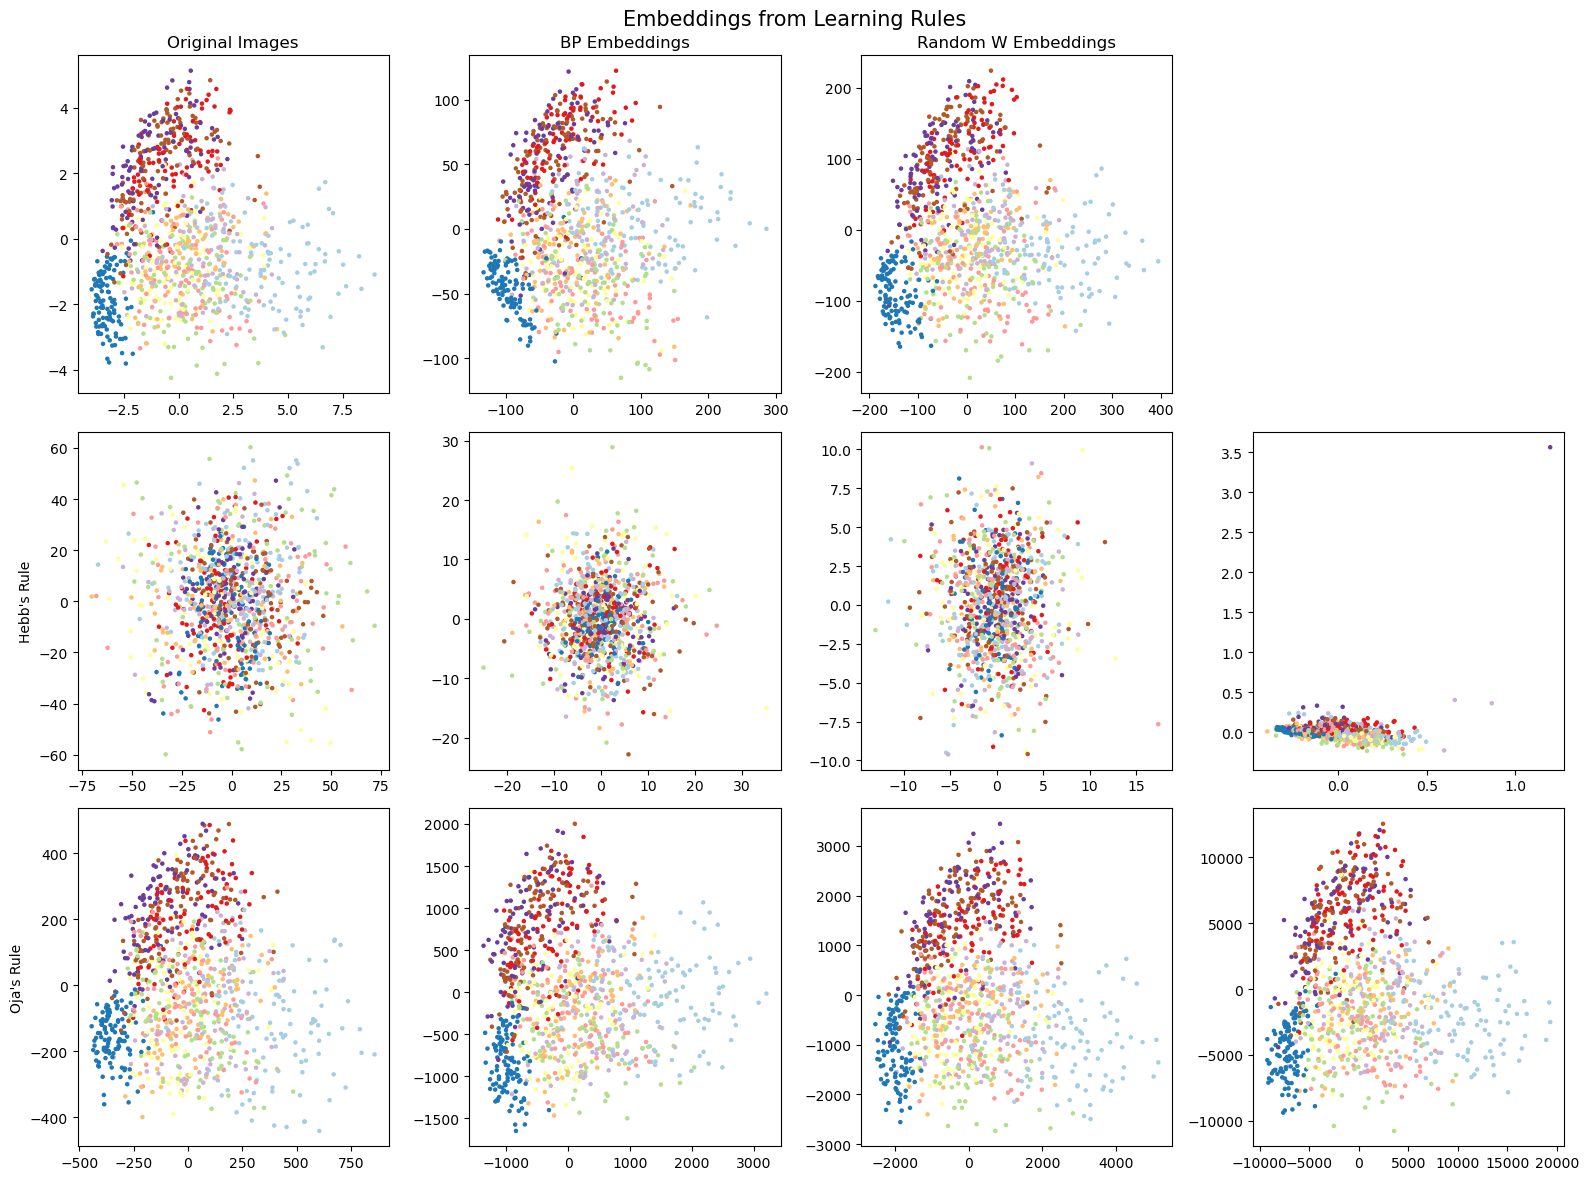

In [59]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

axes[0, 0].scatter(x_proj[:, 0], x_proj[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 1].scatter(Wx_proj_baseline[:, 0], Wx_proj_baseline[:, 1], c=labels, cmap='Paired', s=5)
axes[0, 2].scatter(Wx_proj_random_W[:, 0], Wx_proj_random_W[:, 1], c=labels, cmap='Paired', s=5)

axes[1, 0].scatter(Wx_proj_hebbs_rule1[:, 0], Wx_proj_hebbs_rule1[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 1].scatter(Wx_proj_hebbs_rule5[:, 0], Wx_proj_hebbs_rule5[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 2].scatter(Wx_proj_hebbs_rule10[:, 0], Wx_proj_hebbs_rule10[:, 1], c=labels, cmap='Paired', s=5)
axes[1, 3].scatter(Wx_proj_hebbs_rule50[:, 0], Wx_proj_hebbs_rule50[:, 1], c=labels, cmap='Paired', s=5)

axes[2, 0].scatter(Wx_proj_ojas_rule1[:, 0], Wx_proj_ojas_rule1[:, 1], c=labels, cmap='Paired', s=5)
axes[2, 1].scatter(Wx_proj_ojas_rule5[:, 0], Wx_proj_ojas_rule5[:, 1], c=labels, cmap='Paired', s=5)
axes[2, 2].scatter(Wx_proj_ojas_rule10[:, 0], Wx_proj_ojas_rule10[:, 1], c=labels, cmap='Paired', s=5)
axes[2, 3].scatter(Wx_proj_ojas_rule50[:, 0], Wx_proj_ojas_rule50[:, 1], c=labels, cmap='Paired', s=5)

axes[0, 0].set_title('Original Images')
axes[0, 1].set_title('BP Embeddings')
axes[0, 2].set_title('Random W Embeddings')
axes[0, 3].axis('off')
axes[1, 0].set_ylabel("Hebb's Rule")
# axes[1, 0].set_ylabel()
axes[2, 0].set_ylabel("Oja's Rule")

fig.suptitle('Embeddings from Learning Rules', fontsize=15)
plt.tight_layout()
# fig.savefig('figures/embeddings_comparison.png', dpi=300)

### Unsup neuron cosine similarities

In [47]:
def plot_neuron_similarities(model, num_samples):
    # get and normalize weight matrix
    try:
        W = model.unsup_layer.W
    except:
        W = model.input.weight
    W_normed = F.normalize(W)
    
    # get pairwise cosine similarities
    similarities = torch.matmul(W_normed, W_normed.T)
    similarities = similarities[~torch.eye(similarities.size(0), dtype=bool)].flatten().detach()
    
    # sample similarities
    indices = torch.randperm(similarities.size(0))[:num_samples]
    similarities_sample = similarities[indices]
    
    # plot
    plt.hist(similarities_sample.numpy(), bins=20, range=(-1,1), weights=np.ones(num_samples)/num_samples, edgecolor='black')
    plt.xlabel('Cosine Similarities Between Neurons')
    plt.ylabel('Fraction')
    plt.show()

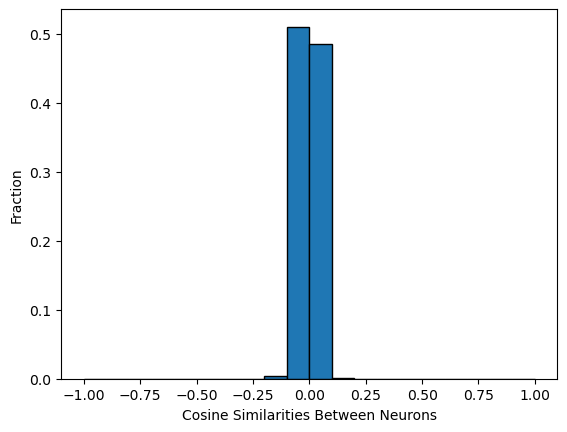

In [485]:
plot_neuron_similarities(ojas_rule50, 1000)

### Unsup synaptic activations in training

In [509]:
from genhebb import GenHebb, hebbs_rule, ojas_rule, hard_WTA_ojas_rule

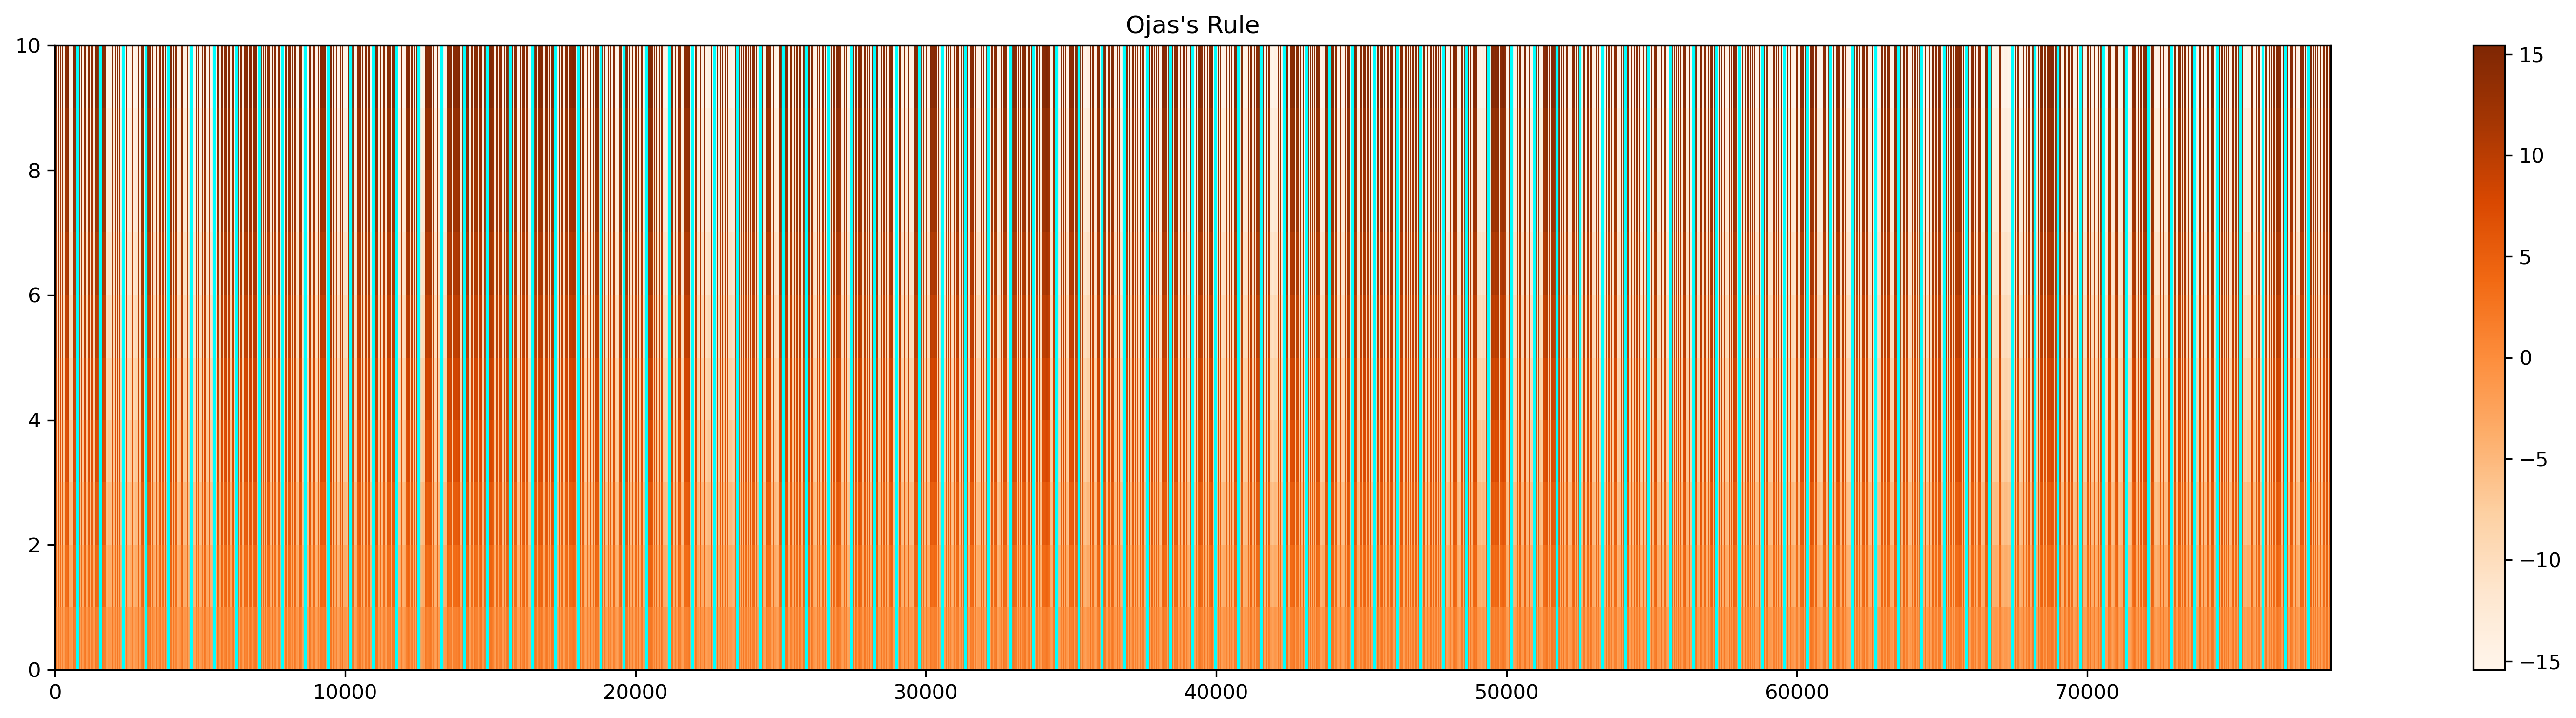

In [501]:
weights = []
for epoch in range(1, 21):
    model = GenHebb(28*28, 100, 10, ojas_rule)
    model.load_state_dict(torch.load(f'saved_models/epoch_checkpoints/ojas_rule_{epoch}.pt'))
    weights.append(model.unsup_layer.W.flatten().detach().numpy())

plt.figure(figsize=(20, 5), dpi=300)
plt.pcolormesh(weights, cmap='Oranges')
for n in range(1, 100):
    plt.axvline(n*784, c='cyan')
plt.colorbar()
plt.title("Ojas's Rule")
plt.tight_layout()
plt.show()

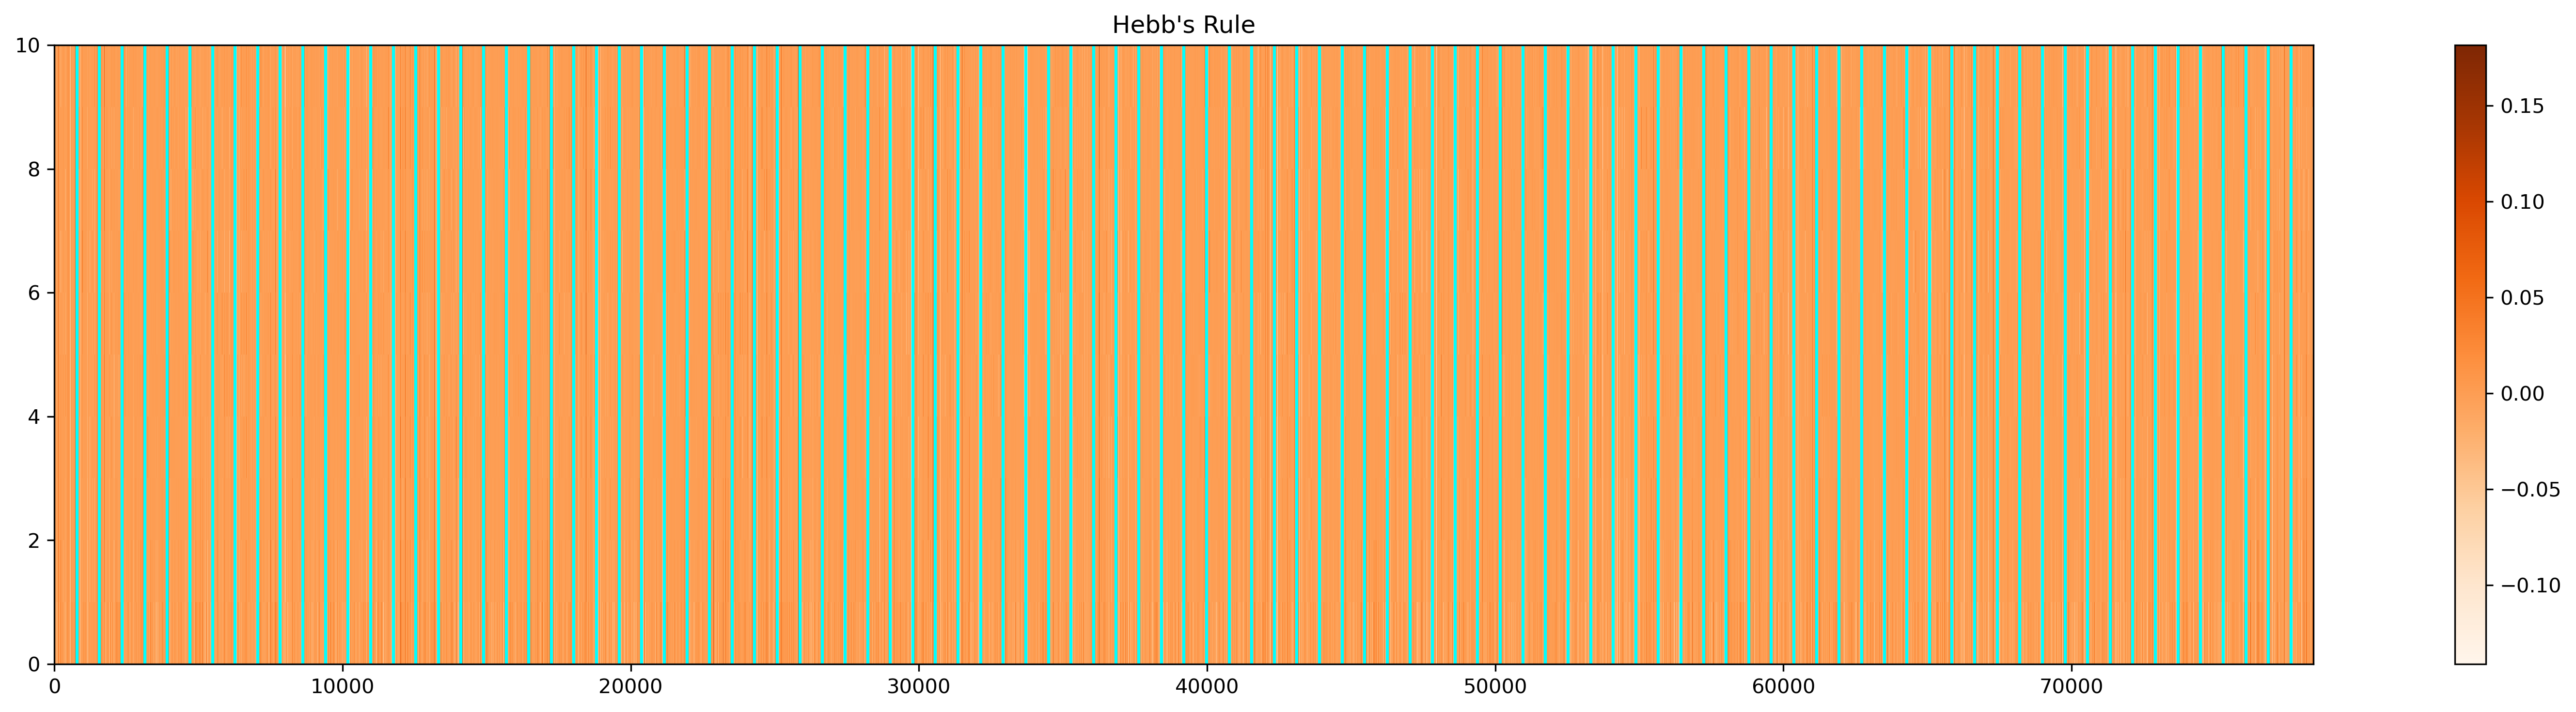

In [502]:
weights = []
for epoch in range(1, 11):
    model = GenHebb(28*28, 100, 10, hebbs_rule)
    model.load_state_dict(torch.load(f'saved_models/epoch_checkpoints/hebbs_rule_{epoch}.pt'))
    weights.append(model.unsup_layer.W.flatten().detach().numpy())

plt.figure(figsize=(20, 5), dpi=300)
plt.pcolormesh(weights, cmap='Oranges')
for n in range(1, 100):
    plt.axvline(n*784, c='cyan')
plt.colorbar()
plt.title("Hebb's Rule")
plt.tight_layout()
plt.show()

In [519]:
weights = []
n_neurons = 5
for epoch in range(1, 11):
    model = GenHebb(28*28, 2000, 10, hard_WTA_ojas_rule)
    model.load_state_dict(torch.load(f'saved_models/mid-training/genhebb-hard_WTA_ojas_rule-1_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch-epoch_{epoch}.pt'))
    weights.append(model.unsup_layer.W.flatten().detach().numpy()[0:n_neurons*784])

plt.figure(figsize=(2*n_neurons, 4), dpi=300)
plt.pcolormesh(weights, cmap='Oranges')
for n in range(1, n_neurons):
    plt.axvline(n*784, c='cyan')
plt.colorbar()
plt.title("Hard WTA Oja's Rule")
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/mid-training/genhebb-hard_WTA_ojas_rule-1_unsup_epochs-50_sup_epochs-0.001_unsup_lr-0.001_sup_lr-64_batch-epoch_2.pt'